In [1]:
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

2.4.0
2.4.3


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11771969550234669553
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 8855182400
locality {
  bus_id: 1
  links {
  }
}
incarnation: 137681549341387087
physical_device_desc: "device: 0, name: GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [4]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
import time

start = time.time()

## Load data

In [5]:
directory = "Testing_data/"
stock_data_list = []

for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    stock_data = pd.read_csv(file_path)
    stock_data = stock_data.rename(columns={'Data': 'Date', 'Otwarcie': 'Open', 'Najwyzszy': 'Highest', 'Najnizszy': 'Lowest', 'Zamkniecie': 'Close', 'Wolumen': 'Volume'})
    stock_data['Date'] = pd.to_datetime(stock_data.Date)
    stock_data_list.append(stock_data)
    print('Loaded file: ' + filename)

for i in range(len(stock_data_list)):
    stock_data_list[i] = stock_data_list[i].dropna()

Loaded file: acp_d.csv
Loaded file: alr_d.csv
Loaded file: ccc_d.csv
Loaded file: cdr_d.csv
Loaded file: dnp_d.csv
Loaded file: kgh_d.csv
Loaded file: pkn_d.csv


In [6]:
def get_moving_average(data, period):
    data['MA'] = data['Close'].rolling(period).mean()
    return data

In [7]:
def get_RSI (data, period):
    increase_difference, decrease_difference = data['Close'].diff(), data['Close'].diff()
    increase_difference[increase_difference < 0] = 0
    decrease_difference[decrease_difference > 0] = 0
    roll_increase = increase_difference.ewm(span = period).mean()
    roll_decrease = decrease_difference.abs().ewm(span = period).mean()
    RS = roll_increase / roll_decrease
    data['RSI'] = 100 - (100 / (1 + RS))
    return data

In [8]:
def get_ROC(data):
    data['ROC'] = data['Close'].pct_change()
    return data

In [9]:
def get_stochastic_oscillator(data, period):
    L14, H14 = data['Close'].rolling(period).min(), data['Close'].rolling(period).max()
    data['K'] = (data['Close'] - L14)/(H14 - L14)
    return data

In [10]:
def get_SO_moving_average(data, so_period, ma_period):
    L14, H14 = data['Close'].rolling(so_period).min(), data['Close'].rolling(so_period).max()
    K = (data['Close'] - L14)/(H14 - L14)
    data['D'] = K.rolling(ma_period).mean()
    return data

In [11]:
def get_MACD(data, period_long, period_short):
    EMA_long = data['Close'].ewm(period_long).mean()
    EMA_short = data['Close'].ewm(period_short).mean()
    data['MACD'] = EMA_short - EMA_long
    return data

In [12]:
def get_MACD_histogram(data, period_long, period_short, period_signal):
    EMA_long = data['Close'].ewm(period_long).mean()
    EMA_short = data['Close'].ewm(period_short).mean()
    MACD = EMA_short - EMA_long
    MACD_signal = MACD.ewm(9).mean()
    data['MACD_Histogram'] = MACD - MACD_signal
    return data

In [13]:
def get_TEMA(data, period):
    SEMA = data['Close'].ewm(period).mean()
    DEMA = SEMA.ewm(period).mean()
    data['TEMA'] = DEMA.ewm(period).mean()
    return(data)

In [14]:
def get_CGI(data, period):
    typical_price = (data['Highest'] + data['Lowest'] + data['Close']) / 3
    MA = typical_price.rolling(period).mean()
    mean_deviation = (MA - typical_price).abs().rolling(period).mean()
    data['CCI'] = (typical_price - MA) / (0.15 * mean_deviation)
    return(data)

In [15]:
def get_Williams_Percent_Range(data, period):
    data['Percent_Range'] = (data['Highest'].rolling(period).max() - data['Close']) / (data['Highest'].rolling(period).max() - data['Lowest'].rolling(period).min())
    return(data)

In [16]:
def scale_data(data):
    list_of_features = []
    for column in data.columns:
        list_of_features.append(data[column])

    dataset = np.transpose(list_of_features)

    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)

    return scaled_data, scaler

In [17]:
def scale_data_X_Y(data):
    list_of_features = []
    list_of_outputs = []
    for column in data.columns:
        list_of_features.append(data[column])
        if column in ['Open', 'Close', 'Highest', 'Lowest', 'Volume']:
            list_of_outputs.append(data[column])
        
    dataset = np.transpose(list_of_features)
    output_dataset = np.transpose(list_of_outputs)
    X_scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = X_scaler.fit_transform(dataset)
    Y_scaler = MinMaxScaler(feature_range=(0,1))
    Y_scaler.fit_transform(output_dataset)

    return scaled_data, X_scaler, Y_scaler

In [18]:
def prepare_input_and_output(data, number_of_sessions=60):
    # number_of_sessions - number of considered previous sessions as an input
    X = []
    Y = []
    for i in range(number_of_sessions, data.shape[0]):
        X.append(data[i-number_of_sessions:i, :])
        Y.append(data[i, :5])
    return X, Y

# Testing for the best technical indicators parameters

In [19]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Checking how algorithm works without techincal indicators (learning based on prices and volume)

In [20]:
X_all = []
Y_all = []
stocks_base = []
results_base = []
# prepare data
for stock in stock_data_list:
    stock = stock.dropna()
    scaled_stock, stock_scaler = scale_data(stock.drop(columns='Date'))
    stocks_base.append(scaled_stock)
# split for training and validation
for stock in stocks_base:
    X, Y = prepare_input_and_output(np.array(stock))
    X_all = X_all + X
    Y_all = Y_all + Y
X_all, Y_all = np.array(X_all), np.array(Y_all)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=0.1, shuffle=False)
print(X_train.shape)
print(X_valid.shape)
print(Y_train.shape)
print(Y_valid.shape)
loss_results = []
val_loss_results = []
for i in range(3):
    model = Sequential()
    model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(Y_train.shape[1]))
    model.compile(loss='mse', optimizer='adam')
    history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
    loss_results.append(history.history['loss'][-1])
    val_loss_results.append(history.history['val_loss'][-1])
results_base.append({'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})
results_base = pd.DataFrame(results_base)

(27145, 60, 5)
(3017, 60, 5)
(27145, 5)
(3017, 5)
Epoch 1/7
849/849 [==============================] - 7s 5ms/step - loss: 0.0128 - val_loss: 7.0935e-04
Epoch 2/7
849/849 [==============================] - 3s 4ms/step - loss: 5.5502e-04 - val_loss: 6.7277e-04
Epoch 3/7
849/849 [==============================] - 3s 4ms/step - loss: 5.1894e-04 - val_loss: 6.3607e-04
Epoch 4/7
849/849 [==============================] - 3s 4ms/step - loss: 4.4351e-04 - val_loss: 5.9816e-04
Epoch 5/7
849/849 [==============================] - 3s 4ms/step - loss: 4.9108e-04 - val_loss: 6.0172e-04
Epoch 6/7
849/849 [==============================] - 3s 4ms/step - loss: 4.3369e-04 - val_loss: 5.9222e-04
Epoch 7/7
849/849 [==============================] - 3s 4ms/step - loss: 4.2999e-04 - val_loss: 5.7015e-04
Epoch 1/7
849/849 [==============================] - 5s 4ms/step - loss: 0.0087 - val_loss: 7.4828e-04
Epoch 2/7
849/849 [==============================] - 3s 4ms/step - loss: 5.6898e-04 - val_loss: 7.2563

In [21]:
results_base

,loss,val_loss
0,0.000434,0.000576


### Moving average

In [22]:
periods = [3, 5, 10, 15, 20, 30, 45, 60, 80, 100, 125, 150, 200]
X_all_MA = []
Y_all_MA = []
results_MA = []


for period in periods:
    X_all_MA = []
    Y_all_MA = []
    stocks_MA = []
    # prepare data
    for stock in stock_data_list:
        stock_MA = get_moving_average(stock, period)
        stock_MA = stock_MA.dropna()
        scaled_stock, stock_scaler = scale_data(stock_MA.drop(columns='Date'))
        stocks_MA.append(scaled_stock)
    # split for training and validation
    for stock_MA in stocks_MA:
        X, Y = prepare_input_and_output(np.array(stock_MA))
        X_all_MA = X_all_MA + X
        Y_all_MA = Y_all_MA + Y
    X_all_MA, Y_all_MA = np.array(X_all_MA), np.array(Y_all_MA)
    X_train, X_valid, Y_train, Y_valid = train_test_split(X_all_MA, Y_all_MA, test_size=0.1, shuffle=False)
    print(X_train.shape)
    print(X_valid.shape)
    print(Y_train.shape)
    print(Y_valid.shape)
    #
    print('Period: ' + str(period))
    loss_results = []
    val_loss_results = []
    for i in range(3):
        model = Sequential()
        model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
        model.add(Dense(10, activation='relu'))
        model.add(Dense(Y_train.shape[1]))
        model.compile(loss='mse', optimizer='adam')
        history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
        loss_results.append(history.history['loss'][-1])
        val_loss_results.append(history.history['val_loss'][-1])
    results_MA.append({'period': period, 'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})
results_MA = pd.DataFrame(results_MA)


(27133, 60, 6)
(3015, 60, 6)
(27133, 5)
(3015, 5)
Period: 3
Epoch 1/7
848/848 [==============================] - 5s 4ms/step - loss: 0.0330 - val_loss: 7.9990e-04
Epoch 2/7
848/848 [==============================] - 3s 4ms/step - loss: 5.4681e-04 - val_loss: 7.9384e-04
Epoch 3/7
848/848 [==============================] - 3s 4ms/step - loss: 5.0764e-04 - val_loss: 8.6814e-04
Epoch 4/7
848/848 [==============================] - 3s 4ms/step - loss: 4.9081e-04 - val_loss: 8.5689e-04
Epoch 5/7
848/848 [==============================] - 3s 4ms/step - loss: 4.8215e-04 - val_loss: 6.9141e-04
Epoch 6/7
848/848 [==============================] - 3s 4ms/step - loss: 5.0016e-04 - val_loss: 6.5720e-04
Epoch 7/7
848/848 [==============================] - 3s 4ms/step - loss: 4.6653e-04 - val_loss: 6.5500e-04
Epoch 1/7
848/848 [==============================] - 5s 4ms/step - loss: 0.0098 - val_loss: 8.4200e-04
Epoch 2/7
848/848 [==============================] - 3s 4ms/step - loss: 5.4792e-04 - val_lo

Epoch 6/7
846/846 [==============================] - 3s 4ms/step - loss: 4.6608e-04 - val_loss: 6.4358e-04
Epoch 7/7
846/846 [==============================] - 3s 4ms/step - loss: 4.3661e-04 - val_loss: 6.5156e-04
Epoch 1/7
846/846 [==============================] - 5s 4ms/step - loss: 0.0158 - val_loss: 9.3360e-04
Epoch 2/7
846/846 [==============================] - 3s 4ms/step - loss: 6.1308e-04 - val_loss: 8.0001e-04
Epoch 3/7
846/846 [==============================] - 3s 4ms/step - loss: 5.1654e-04 - val_loss: 7.5434e-04
Epoch 4/7
846/846 [==============================] - 3s 4ms/step - loss: 5.0419e-04 - val_loss: 7.8897e-04
Epoch 5/7
846/846 [==============================] - 3s 4ms/step - loss: 4.7903e-04 - val_loss: 6.7000e-04
Epoch 6/7
846/846 [==============================] - 3s 4ms/step - loss: 4.6128e-04 - val_loss: 7.4563e-04
Epoch 7/7
846/846 [==============================] - 3s 4ms/step - loss: 4.4630e-04 - val_loss: 6.5622e-04
(27026, 60, 6)
(3003, 60, 6)
(27026, 5)
(

837/837 [==============================] - 3s 4ms/step - loss: 5.1027e-04 - val_loss: 7.5379e-04
Epoch 4/7
837/837 [==============================] - 4s 4ms/step - loss: 4.8451e-04 - val_loss: 6.6631e-04
Epoch 5/7
837/837 [==============================] - 3s 4ms/step - loss: 4.8415e-04 - val_loss: 6.7935e-04
Epoch 6/7
837/837 [==============================] - 3s 4ms/step - loss: 4.7346e-04 - val_loss: 6.8087e-04
Epoch 7/7
837/837 [==============================] - 3s 4ms/step - loss: 4.4718e-04 - val_loss: 6.6228e-04
Epoch 1/7
837/837 [==============================] - 5s 4ms/step - loss: 0.0078 - val_loss: 8.8769e-04
Epoch 2/7
837/837 [==============================] - 3s 4ms/step - loss: 5.5686e-04 - val_loss: 7.4683e-04
Epoch 3/7
837/837 [==============================] - 3s 4ms/step - loss: 5.6081e-04 - val_loss: 6.9115e-04
Epoch 4/7
837/837 [==============================] - 4s 4ms/step - loss: 5.0796e-04 - val_loss: 6.8824e-04
Epoch 5/7
837/837 [==============================] 

824/824 [==============================] - 5s 5ms/step - loss: 0.0205 - val_loss: 9.7400e-04
Epoch 2/7
824/824 [==============================] - 3s 4ms/step - loss: 6.0622e-04 - val_loss: 7.5737e-04
Epoch 3/7
824/824 [==============================] - 3s 4ms/step - loss: 5.8085e-04 - val_loss: 7.6807e-04
Epoch 4/7
824/824 [==============================] - 3s 4ms/step - loss: 5.5442e-04 - val_loss: 6.9163e-04
Epoch 5/7
824/824 [==============================] - 3s 4ms/step - loss: 5.3552e-04 - val_loss: 6.6588e-04
Epoch 6/7
824/824 [==============================] - 4s 4ms/step - loss: 4.8989e-04 - val_loss: 6.3636e-04
Epoch 7/7
824/824 [==============================] - 4s 5ms/step - loss: 4.5785e-04 - val_loss: 6.2487e-04
(26207, 60, 6)
(2912, 60, 6)
(26207, 5)
(2912, 5)
Period: 150
Epoch 1/7
819/819 [==============================] - 5s 5ms/step - loss: 0.0126 - val_loss: 7.6106e-04
Epoch 2/7
819/819 [==============================] - 3s 4ms/step - loss: 5.6607e-04 - val_loss: 7.41

In [23]:
results_MA

,period,loss,val_loss
0,3,0.000452,0.000695
1,5,0.000451,0.000646
2,10,0.000454,0.000670
3,15,0.000456,0.000651
4,20,0.000450,0.000644
5,30,0.000458,0.000680
6,45,0.000452,0.000646
7,60,0.000459,0.000654
8,80,0.000456,0.000629
9,100,0.000451,0.000638


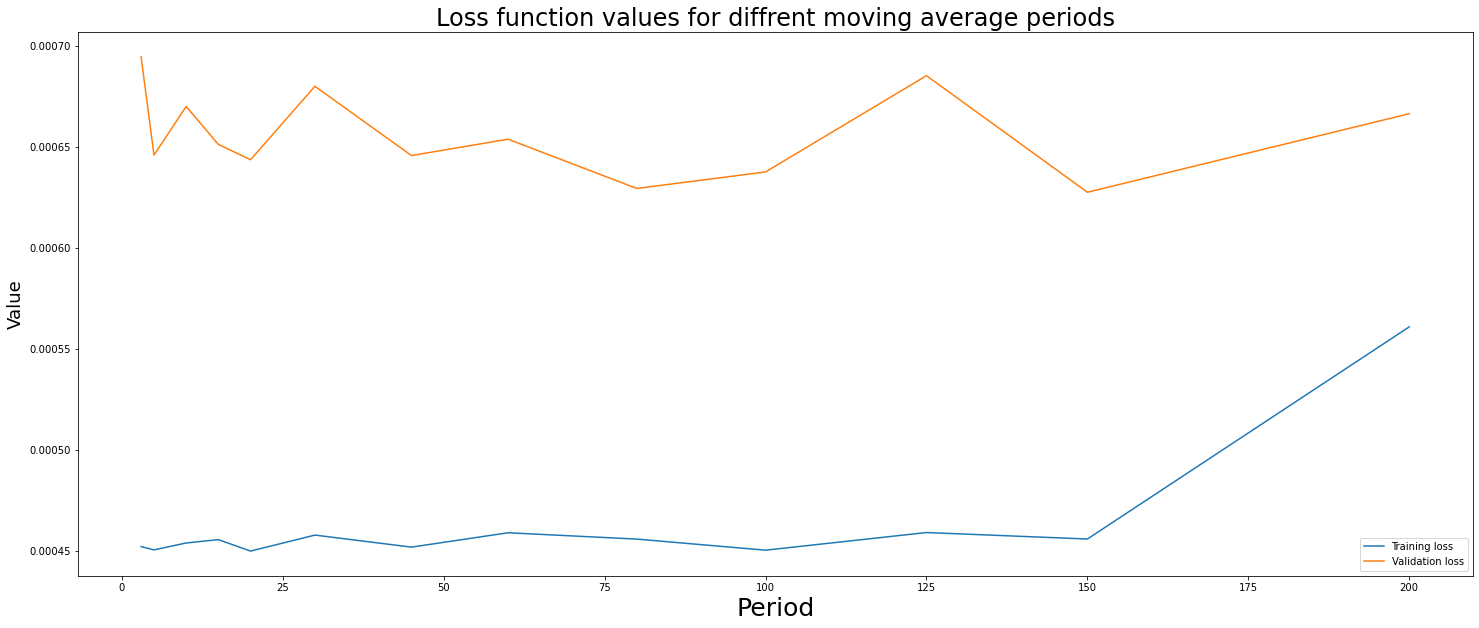

In [24]:
plt.figure(figsize=(25,10))
plt.title('Loss function values for diffrent moving average periods', fontsize=24)
plt.xlabel('Period', fontsize=25)
plt.ylabel('Value', fontsize=18)
plt.plot(results_MA['period'], results_MA[['loss', 'val_loss']])
plt.legend(['Training loss',  'Validation loss'], loc='lower right')
plt.axhline(0.000444, color='r', label = 'Loss without indicator')
plt.show()

### RSI

In [25]:
periods = [3, 5, 7, 10, 14]
X_all = []
Y_all = []
results_RSI = []


for period in periods:
    X_all = []
    Y_all = []
    stocks = []
    # prepare data
    for stock in stock_data_list:
        stock = get_RSI(stock, period)
        stock = stock.dropna()
        scaled_stock, stock_scaler = scale_data(stock.drop(columns='Date'))
        stocks.append(scaled_stock)
    # split for training and validation
    for stock in stocks:
        X, Y = prepare_input_and_output(np.array(stock))
        X_all = X_all + X
        Y_all = Y_all + Y
    X_all, Y_all = np.array(X_all), np.array(Y_all)
    X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=0.1, shuffle=False)
    print(X_train.shape)
    print(X_valid.shape)
    print(Y_train.shape)
    print(Y_valid.shape)
    #
    print('Period: ' + str(period))
    loss_results = []
    val_loss_results = []
    for i in range(3):
        model = Sequential()
        model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
        model.add(Dense(10, activation='relu'))
        model.add(Dense(Y_train.shape[1]))
        model.compile(loss='mse', optimizer='adam')
        history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
        loss_results.append(history.history['loss'][-1])
        val_loss_results.append(history.history['val_loss'][-1])
    results_RSI.append({'period': period, 'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})
results_RSI = pd.DataFrame(results_RSI)


(25892, 60, 7)
(2877, 60, 7)
(25892, 5)
(2877, 5)
Period: 3
Epoch 1/7
810/810 [==============================] - 5s 5ms/step - loss: 0.0129 - val_loss: 7.2325e-04
Epoch 2/7
810/810 [==============================] - 3s 4ms/step - loss: 6.1904e-04 - val_loss: 6.7378e-04
Epoch 3/7
810/810 [==============================] - 3s 4ms/step - loss: 6.2181e-04 - val_loss: 8.6731e-04
Epoch 4/7
810/810 [==============================] - 3s 4ms/step - loss: 6.4667e-04 - val_loss: 7.5597e-04
Epoch 5/7
810/810 [==============================] - 3s 4ms/step - loss: 5.4055e-04 - val_loss: 6.0738e-04
Epoch 6/7
810/810 [==============================] - 3s 4ms/step - loss: 5.2858e-04 - val_loss: 6.2953e-04
Epoch 7/7
810/810 [==============================] - 3s 4ms/step - loss: 5.5865e-04 - val_loss: 6.0760e-04
Epoch 1/7
810/810 [==============================] - 5s 5ms/step - loss: 0.0099 - val_loss: 7.9179e-04
Epoch 2/7
810/810 [==============================] - 4s 4ms/step - loss: 5.9010e-04 - val_lo

810/810 [==============================] - 3s 4ms/step - loss: 5.5688e-04 - val_loss: 6.5947e-04
Epoch 6/7
810/810 [==============================] - 3s 4ms/step - loss: 5.9875e-04 - val_loss: 6.2907e-04
Epoch 7/7
810/810 [==============================] - 3s 4ms/step - loss: 5.8919e-04 - val_loss: 6.0733e-04
Epoch 1/7
810/810 [==============================] - 5s 5ms/step - loss: 0.0127 - val_loss: 7.0647e-04
Epoch 2/7
810/810 [==============================] - 3s 4ms/step - loss: 6.4761e-04 - val_loss: 6.4319e-04
Epoch 3/7
810/810 [==============================] - 4s 5ms/step - loss: 5.8814e-04 - val_loss: 7.8616e-04
Epoch 4/7
810/810 [==============================] - 4s 5ms/step - loss: 5.9886e-04 - val_loss: 6.0618e-04
Epoch 5/7
810/810 [==============================] - 3s 4ms/step - loss: 5.2814e-04 - val_loss: 6.1681e-04
Epoch 6/7
810/810 [==============================] - 3s 4ms/step - loss: 5.1348e-04 - val_loss: 6.2308e-04
Epoch 7/7
810/810 [==============================] 

In [26]:
results_RSI

,period,loss,val_loss
0,3,0.000551,0.000647
1,5,0.000555,0.000616
2,7,0.000553,0.000624
3,10,0.000550,0.000625
4,14,0.000551,0.000640


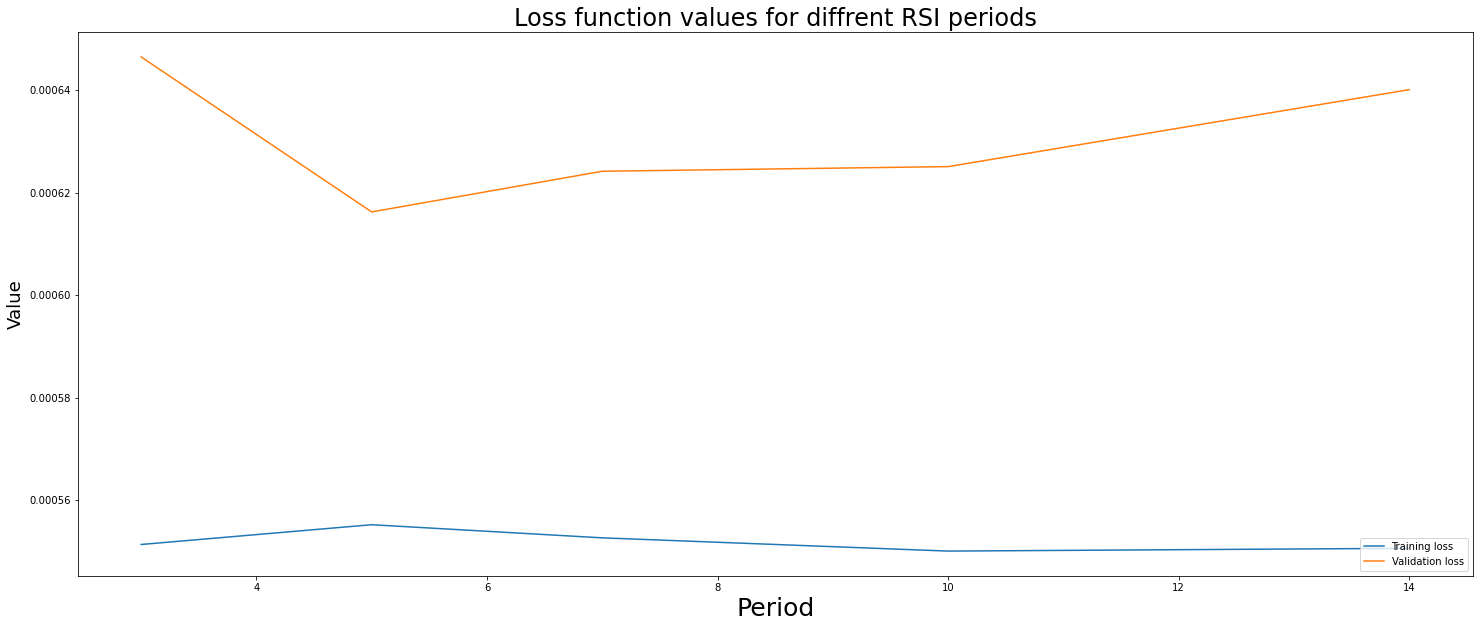

In [27]:
plt.figure(figsize=(25,10))
plt.title('Loss function values for diffrent RSI periods', fontsize=24)
plt.xlabel('Period', fontsize=25)
plt.ylabel('Value', fontsize=18)
plt.plot(results_RSI['period'], results_RSI[['loss', 'val_loss']])
plt.legend(['Training loss',  'Validation loss'], loc='lower right')
plt.axhline(0.000444, color='r', label = 'Loss without indicator')
plt.show()

## ROC

In [28]:
X_all = []
Y_all = []
results_ROC = []


X_all = []
Y_all = []
stocks = []
# prepare data
for stock in stock_data_list:
    stock = get_ROC(stock)
    stock = stock.dropna()
    scaled_stock, stock_scaler = scale_data(stock.drop(columns='Date'))
    stocks.append(scaled_stock)
# split for training and validation
for stock in stocks:
    X, Y = prepare_input_and_output(np.array(stock))
    X_all = X_all + X
    Y_all = Y_all + Y
X_all, Y_all = np.array(X_all), np.array(Y_all)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=0.1, shuffle=False)
print(X_train.shape)
print(X_valid.shape)
print(Y_train.shape)
print(Y_valid.shape)

loss_results = []
val_loss_results = []
for i in range(3):
    model = Sequential()
    model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(Y_train.shape[1]))
    model.compile(loss='mse', optimizer='adam')
    history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
    loss_results.append(history.history['loss'][-1])
    val_loss_results.append(history.history['val_loss'][-1])
results_ROC.append({'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})
results_ROC = pd.DataFrame(results_ROC)

(25892, 60, 8)
(2877, 60, 8)
(25892, 5)
(2877, 5)
Epoch 1/7
810/810 [==============================] - 5s 5ms/step - loss: 0.0076 - val_loss: 7.1482e-04
Epoch 2/7
810/810 [==============================] - 3s 4ms/step - loss: 6.1247e-04 - val_loss: 6.2723e-04
Epoch 3/7
810/810 [==============================] - 3s 4ms/step - loss: 5.6478e-04 - val_loss: 6.5235e-04
Epoch 4/7
810/810 [==============================] - 3s 4ms/step - loss: 5.6965e-04 - val_loss: 6.2361e-04
Epoch 5/7
810/810 [==============================] - 4s 4ms/step - loss: 5.4704e-04 - val_loss: 6.3266e-04
Epoch 6/7
810/810 [==============================] - 4s 4ms/step - loss: 5.2880e-04 - val_loss: 6.7069e-04
Epoch 7/7
810/810 [==============================] - 4s 4ms/step - loss: 5.3540e-04 - val_loss: 6.0542e-04
Epoch 1/7
810/810 [==============================] - 5s 5ms/step - loss: 0.0163 - val_loss: 7.1023e-04
Epoch 2/7
810/810 [==============================] - 3s 4ms/step - loss: 6.4947e-04 - val_loss: 7.3312

In [29]:
results_ROC

,loss,val_loss
0,0.000545,0.000638


## Stochastic oscillator

In [30]:
periods = [3, 5, 7, 10, 14]
X_all = []
Y_all = []
results_SO = []


for period in periods:
    X_all = []
    Y_all = []
    stocks = []
    # prepare data
    for stock in stock_data_list:
        stock = get_stochastic_oscillator(stock, period)
        stock = stock.dropna()
        scaled_stock, stock_scaler = scale_data(stock.drop(columns='Date'))
        stocks.append(scaled_stock)
    # split for training and validation
    for stock in stocks:
        X, Y = prepare_input_and_output(np.array(stock))
        X_all = X_all + X
        Y_all = Y_all + Y
    X_all, Y_all = np.array(X_all), np.array(Y_all)
    X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=0.1, shuffle=False)
    print(X_train.shape)
    print(X_valid.shape)
    print(Y_train.shape)
    print(Y_valid.shape)
    #
    print('Period: ' + str(period))
    loss_results = []
    val_loss_results = []
    for i in range(3):
        model = Sequential()
        model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
        model.add(Dense(10, activation='relu'))
        model.add(Dense(Y_train.shape[1]))
        model.compile(loss='mse', optimizer='adam')
        history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
        loss_results.append(history.history['loss'][-1])
        val_loss_results.append(history.history['val_loss'][-1])
    results_SO.append({'period': period, 'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})
results_SO = pd.DataFrame(results_SO)


(25738, 60, 9)
(2860, 60, 9)
(25738, 5)
(2860, 5)
Period: 3
Epoch 1/7
805/805 [==============================] - 5s 5ms/step - loss: 0.0144 - val_loss: 8.0594e-04
Epoch 2/7
805/805 [==============================] - 3s 4ms/step - loss: 6.2378e-04 - val_loss: 7.8288e-04
Epoch 3/7
805/805 [==============================] - 4s 5ms/step - loss: 6.2831e-04 - val_loss: 6.4828e-04
Epoch 4/7
805/805 [==============================] - 4s 4ms/step - loss: 6.1651e-04 - val_loss: 6.7065e-04
Epoch 5/7
805/805 [==============================] - 3s 4ms/step - loss: 5.5729e-04 - val_loss: 6.6497e-04
Epoch 6/7
805/805 [==============================] - 3s 4ms/step - loss: 5.7930e-04 - val_loss: 6.4557e-04
Epoch 7/7
805/805 [==============================] - 4s 5ms/step - loss: 5.5008e-04 - val_loss: 6.0625e-04
Epoch 1/7
805/805 [==============================] - 5s 5ms/step - loss: 0.0314 - val_loss: 8.5423e-04
Epoch 2/7
805/805 [==============================] - 3s 4ms/step - loss: 7.8168e-04 - val_lo

Epoch 6/7
810/810 [==============================] - 3s 4ms/step - loss: 5.8625e-04 - val_loss: 5.9747e-04
Epoch 7/7
810/810 [==============================] - 3s 4ms/step - loss: 5.3207e-04 - val_loss: 7.3188e-04
Epoch 1/7
810/810 [==============================] - 6s 6ms/step - loss: 0.0572 - val_loss: 0.0190
Epoch 2/7
810/810 [==============================] - 4s 4ms/step - loss: 0.0054 - val_loss: 0.0042
Epoch 3/7
810/810 [==============================] - 3s 4ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 4/7
810/810 [==============================] - 4s 4ms/step - loss: 9.1674e-04 - val_loss: 9.0675e-04
Epoch 5/7
810/810 [==============================] - 3s 4ms/step - loss: 6.6750e-04 - val_loss: 7.4797e-04
Epoch 6/7
810/810 [==============================] - 4s 5ms/step - loss: 5.9568e-04 - val_loss: 6.5755e-04
Epoch 7/7
810/810 [==============================] - 4s 5ms/step - loss: 5.7314e-04 - val_loss: 6.2265e-04
(25892, 60, 9)
(2877, 60, 9)
(25892, 5)
(2877, 5)
Period: 14


In [31]:
results_SO

,period,loss,val_loss
0,3,0.000549,0.000624
1,5,0.000549,0.000697
2,7,0.000549,0.000634
3,10,0.000556,0.000666
4,14,0.000549,0.000642


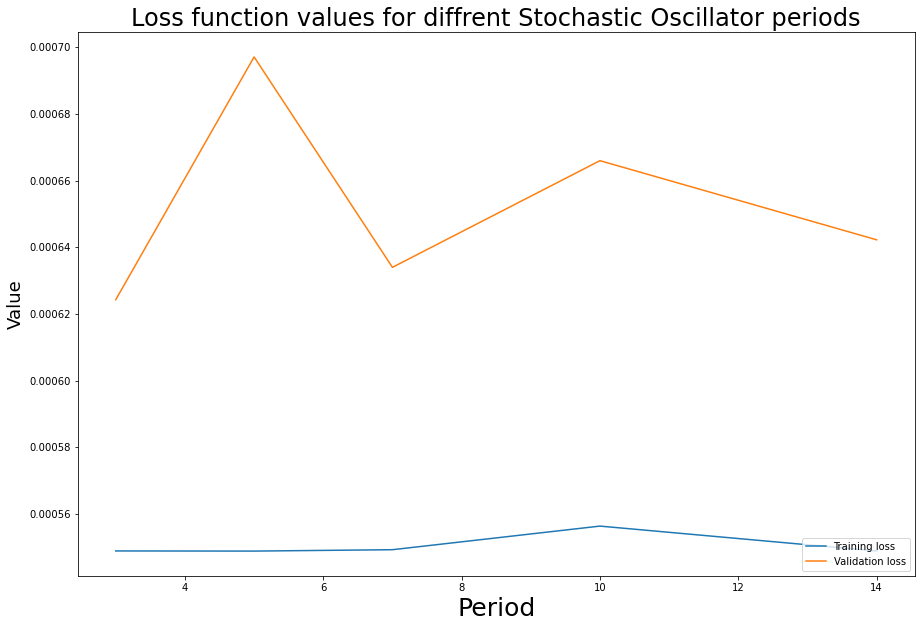

In [32]:
plt.figure(figsize=(15,10))
plt.title('Loss function values for diffrent Stochastic Oscillator periods', fontsize=24)
plt.xlabel('Period', fontsize=25)
plt.ylabel('Value', fontsize=18)
plt.plot(results_SO['period'], results_SO[['loss', 'val_loss']])
plt.legend(['Training loss',  'Validation loss'], loc='lower right')
plt.axhline(0.000444, color='r', label = 'Loss without indicator')
plt.show()

In [33]:
so_periods = [3, 5, 7] #, 10, 14]
ma_periods = [2, 3, 4] #, 5, 6]
X_all = []
Y_all = []
results_SO_MA = []


for so_period in so_periods:
    for ma_period in ma_periods:
        X_all = []
        Y_all = []
        stocks = []
        # prepare data
        for stock in stock_data_list:
            stock = get_SO_moving_average(stock, so_period, ma_period)
            stock = stock.dropna()
            scaled_stock, stock_scaler = scale_data(stock.drop(columns='Date'))
            stocks.append(scaled_stock)
        # split for training and validation
        for stock in stocks:
            X, Y = prepare_input_and_output(np.array(stock))
            X_all = X_all + X
            Y_all = Y_all + Y
        X_all, Y_all = np.array(X_all), np.array(Y_all)
        X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=0.1, shuffle=False)
        print(X_train.shape)
        print(X_valid.shape)
        print(Y_train.shape)
        print(Y_valid.shape)
        #
        print('Stochastic Oscillator period: ' + str(so_period))
        print('Moving average period: ' + str(ma_period))
        loss_results = []
        val_loss_results = []
        for i in range(3):
            model = Sequential()
            model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
            model.add(Dense(10, activation='relu'))
            model.add(Dense(Y_train.shape[1]))
            model.compile(loss='mse', optimizer='adam')
            history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
            loss_results.append(history.history['loss'][-1])
            val_loss_results.append(history.history['val_loss'][-1])
        results_SO_MA.append({'so_period': so_period, 'ma_period': ma_period, 'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})
results_SO_MA = pd.DataFrame(results_SO_MA)


(25615, 60, 10)
(2847, 60, 10)
(25615, 5)
(2847, 5)
Stochastic Oscillator period: 3
Moving average period: 2
Epoch 1/7
801/801 [==============================] - 5s 5ms/step - loss: 0.0128 - val_loss: 0.0013
Epoch 2/7
801/801 [==============================] - 3s 4ms/step - loss: 7.1490e-04 - val_loss: 7.2686e-04
Epoch 3/7
801/801 [==============================] - 3s 4ms/step - loss: 6.1678e-04 - val_loss: 7.1698e-04
Epoch 4/7
801/801 [==============================] - 3s 4ms/step - loss: 5.9855e-04 - val_loss: 6.2438e-04
Epoch 5/7
801/801 [==============================] - 3s 4ms/step - loss: 6.0267e-04 - val_loss: 7.0798e-04
Epoch 6/7
801/801 [==============================] - 3s 4ms/step - loss: 5.8227e-04 - val_loss: 6.9242e-04
Epoch 7/7
801/801 [==============================] - 3s 4ms/step - loss: 5.7374e-04 - val_loss: 6.5977e-04
Epoch 1/7
801/801 [==============================] - 5s 5ms/step - loss: 0.0083 - val_loss: 7.2990e-04
Epoch 2/7
801/801 [============================

Epoch 4/7
809/809 [==============================] - 5s 6ms/step - loss: 6.2234e-04 - val_loss: 6.6186e-04
Epoch 5/7
809/809 [==============================] - 5s 6ms/step - loss: 5.4596e-04 - val_loss: 6.2624e-04
Epoch 6/7
809/809 [==============================] - 5s 6ms/step - loss: 5.9018e-04 - val_loss: 6.1578e-04
Epoch 7/7
809/809 [==============================] - 5s 6ms/step - loss: 5.7939e-04 - val_loss: 6.0992e-04
Epoch 1/7
809/809 [==============================] - 6s 7ms/step - loss: 0.0201 - val_loss: 6.6883e-04
Epoch 2/7
809/809 [==============================] - 5s 6ms/step - loss: 6.6564e-04 - val_loss: 6.9882e-04
Epoch 3/7
809/809 [==============================] - 5s 6ms/step - loss: 5.7314e-04 - val_loss: 6.8350e-04
Epoch 4/7
809/809 [==============================] - 5s 6ms/step - loss: 5.6272e-04 - val_loss: 6.2690e-04
Epoch 5/7
809/809 [==============================] - 5s 6ms/step - loss: 5.5320e-04 - val_loss: 6.0726e-04
Epoch 6/7
809/809 [======================

(25887, 60, 10)
(2877, 60, 10)
(25887, 5)
(2877, 5)
Stochastic Oscillator period: 7
Moving average period: 3
Epoch 1/7
809/809 [==============================] - 8s 8ms/step - loss: 0.0111 - val_loss: 7.8832e-04
Epoch 2/7
809/809 [==============================] - 5s 7ms/step - loss: 6.6896e-04 - val_loss: 8.0722e-04
Epoch 3/7
809/809 [==============================] - 5s 7ms/step - loss: 5.8001e-04 - val_loss: 7.0514e-04
Epoch 4/7
809/809 [==============================] - 5s 7ms/step - loss: 5.8040e-04 - val_loss: 6.1653e-04
Epoch 5/7
809/809 [==============================] - 6s 7ms/step - loss: 5.6331e-04 - val_loss: 6.8043e-04
Epoch 6/7
809/809 [==============================] - 6s 7ms/step - loss: 5.8795e-04 - val_loss: 6.1272e-04
Epoch 7/7
809/809 [==============================] - 6s 7ms/step - loss: 5.2823e-04 - val_loss: 6.7059e-04
Epoch 1/7
809/809 [==============================] - 8s 8ms/step - loss: 0.0052 - val_loss: 7.1266e-04
Epoch 2/7
809/809 [========================

In [34]:
results_SO_MA

,so_period,ma_period,loss,val_loss
0,3,2,0.000557,0.000619
1,3,3,0.000559,0.000612
2,3,4,0.000561,0.000618
3,5,2,0.000551,0.000624
4,5,3,0.000551,0.000633
5,5,4,0.000550,0.000669
6,7,2,0.000554,0.000612
7,7,3,0.000549,0.000635
8,7,4,0.000554,0.000609


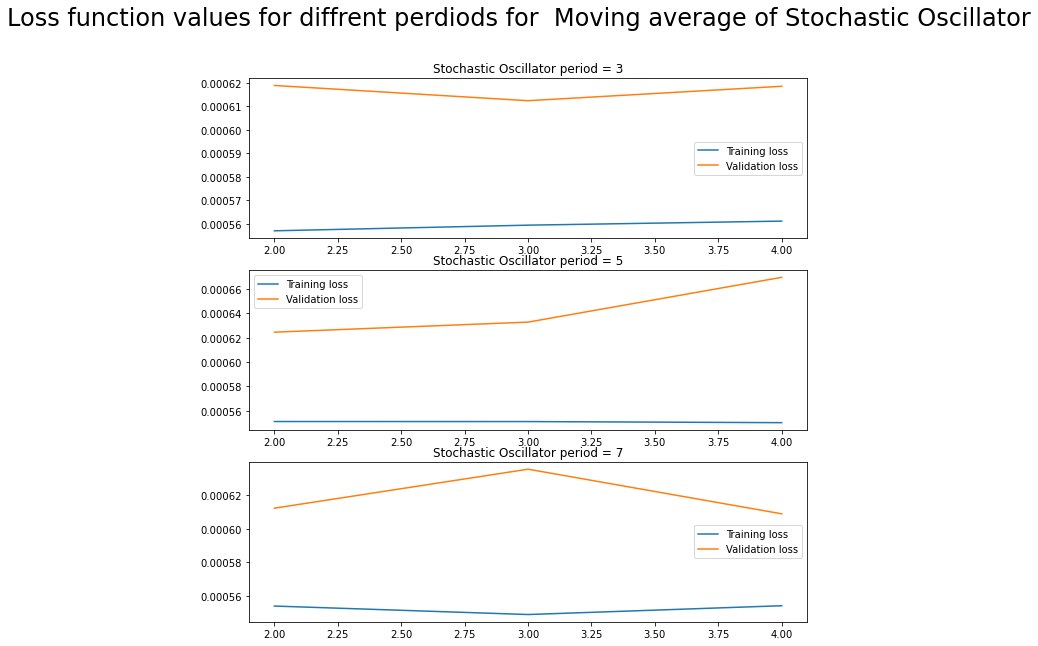

In [35]:
fig, axes = plt.subplots(len(results_SO_MA['so_period'].unique()))
fig.set_size_inches(10,10)
fig.suptitle('Loss function values for diffrent perdiods for  Moving average of Stochastic Oscillator', size=24)

axes_counter = 0
for so_period in results_SO_MA['so_period'].unique():
    axes[axes_counter].title.set_text('Stochastic Oscillator period = ' + str(so_period))
    axes[axes_counter].plot(results_SO_MA['ma_period'].where(results_SO_MA['so_period']==so_period), results_SO_MA[['loss', 'val_loss']].where(results_SO_MA['so_period']==so_period))
    axes[axes_counter].legend(['Training loss',  'Validation loss'])
    axes_counter += 1

In [36]:
long_periods = [10, 18, 26] #, 10, 14]
short_periods = [6, 9, 12] #, 5, 6]
X_all = []
Y_all = []
results_MACD = []


for long_period in long_periods:
    for short_period in short_periods:
        if long_period <= short_period:
            continue
        X_all = []
        Y_all = []
        stocks = []
        # prepare data
        for stock in stock_data_list:
            stock = get_MACD(stock, long_period, short_period)
            stock = stock.dropna()
            scaled_stock, stock_scaler = scale_data(stock.drop(columns='Date'))
            stocks.append(scaled_stock)
        # split for training and validation
        for stock in stocks:
            X, Y = prepare_input_and_output(np.array(stock))
            X_all = X_all + X
            Y_all = Y_all + Y
        X_all, Y_all = np.array(X_all), np.array(Y_all)
        X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=0.1, shuffle=False)
        print(X_train.shape)
        print(X_valid.shape)
        print(Y_train.shape)
        print(Y_valid.shape)
        #
        print('Long period: ' + str(so_period))
        print('Short period: ' + str(ma_period))
        loss_results = []
        val_loss_results = []
        for i in range(3):
            model = Sequential()
            model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
            model.add(Dense(10, activation='relu'))
            model.add(Dense(Y_train.shape[1]))
            model.compile(loss='mse', optimizer='adam')
            history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
            loss_results.append(history.history['loss'][-1])
            val_loss_results.append(history.history['val_loss'][-1])
        results_MACD.append({'long_period': long_period, 'short_period': short_period, 'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})
results_MACD = pd.DataFrame(results_MACD)


(25886, 60, 11)
(2877, 60, 11)
(25886, 5)
(2877, 5)
Long period: 7
Short period: 4
Epoch 1/7
809/809 [==============================] - 6s 6ms/step - loss: 0.0109 - val_loss: 7.6856e-04
Epoch 2/7
809/809 [==============================] - 4s 6ms/step - loss: 8.0069e-04 - val_loss: 7.1104e-04
Epoch 3/7
809/809 [==============================] - 5s 6ms/step - loss: 6.4456e-04 - val_loss: 6.3102e-04
Epoch 4/7
809/809 [==============================] - 5s 6ms/step - loss: 6.1494e-04 - val_loss: 7.4046e-04
Epoch 5/7
809/809 [==============================] - 5s 6ms/step - loss: 5.5432e-04 - val_loss: 6.3967e-04
Epoch 6/7
809/809 [==============================] - 4s 6ms/step - loss: 5.7161e-04 - val_loss: 6.1413e-04
Epoch 7/7
809/809 [==============================] - 5s 6ms/step - loss: 5.4317e-04 - val_loss: 6.4935e-04
Epoch 1/7
809/809 [==============================] - 6s 6ms/step - loss: 0.0069 - val_loss: 7.8512e-04
Epoch 2/7
809/809 [==============================] - 5s 6ms/step - lo

Epoch 5/7
809/809 [==============================] - 5s 6ms/step - loss: 5.8617e-04 - val_loss: 6.1756e-04
Epoch 6/7
809/809 [==============================] - 5s 6ms/step - loss: 6.1526e-04 - val_loss: 6.9218e-04
Epoch 7/7
809/809 [==============================] - 5s 6ms/step - loss: 5.4896e-04 - val_loss: 6.0708e-04
Epoch 1/7
809/809 [==============================] - 6s 6ms/step - loss: 0.0036 - val_loss: 7.1809e-04
Epoch 2/7
809/809 [==============================] - 4s 5ms/step - loss: 6.6654e-04 - val_loss: 6.5464e-04
Epoch 3/7
809/809 [==============================] - 4s 5ms/step - loss: 5.7662e-04 - val_loss: 7.3976e-04
Epoch 4/7
809/809 [==============================] - 4s 6ms/step - loss: 5.7902e-04 - val_loss: 6.3027e-04
Epoch 5/7
809/809 [==============================] - 4s 6ms/step - loss: 5.1486e-04 - val_loss: 6.7246e-04
Epoch 6/7
809/809 [==============================] - 4s 5ms/step - loss: 5.5324e-04 - val_loss: 6.6070e-04
Epoch 7/7
809/809 [======================

Epoch 2/7
809/809 [==============================] - 5s 6ms/step - loss: 6.5032e-04 - val_loss: 6.6464e-04
Epoch 3/7
809/809 [==============================] - 5s 6ms/step - loss: 5.5536e-04 - val_loss: 7.2151e-04
Epoch 4/7
809/809 [==============================] - 5s 6ms/step - loss: 5.9853e-04 - val_loss: 6.3969e-04
Epoch 5/7
809/809 [==============================] - 5s 6ms/step - loss: 5.8408e-04 - val_loss: 6.0353e-04
Epoch 6/7
809/809 [==============================] - 5s 6ms/step - loss: 5.4641e-04 - val_loss: 6.7334e-04
Epoch 7/7
809/809 [==============================] - 5s 6ms/step - loss: 5.3301e-04 - val_loss: 6.6502e-04
Epoch 1/7
809/809 [==============================] - 6s 6ms/step - loss: 0.0048 - val_loss: 6.8972e-04
Epoch 2/7
809/809 [==============================] - 4s 6ms/step - loss: 6.0045e-04 - val_loss: 6.8021e-04
Epoch 3/7
809/809 [==============================] - 4s 6ms/step - loss: 5.6633e-04 - val_loss: 7.4686e-04
Epoch 4/7
809/809 [======================

In [37]:
results_MACD

,long_period,short_period,loss,val_loss
0,10,6,0.000553,0.000613
1,10,9,0.000541,0.000637
2,18,6,0.000556,0.000644
3,18,9,0.000550,0.000604
4,18,12,0.000561,0.000630
5,26,6,0.000553,0.000604
6,26,9,0.000549,0.000609
7,26,12,0.000550,0.000651


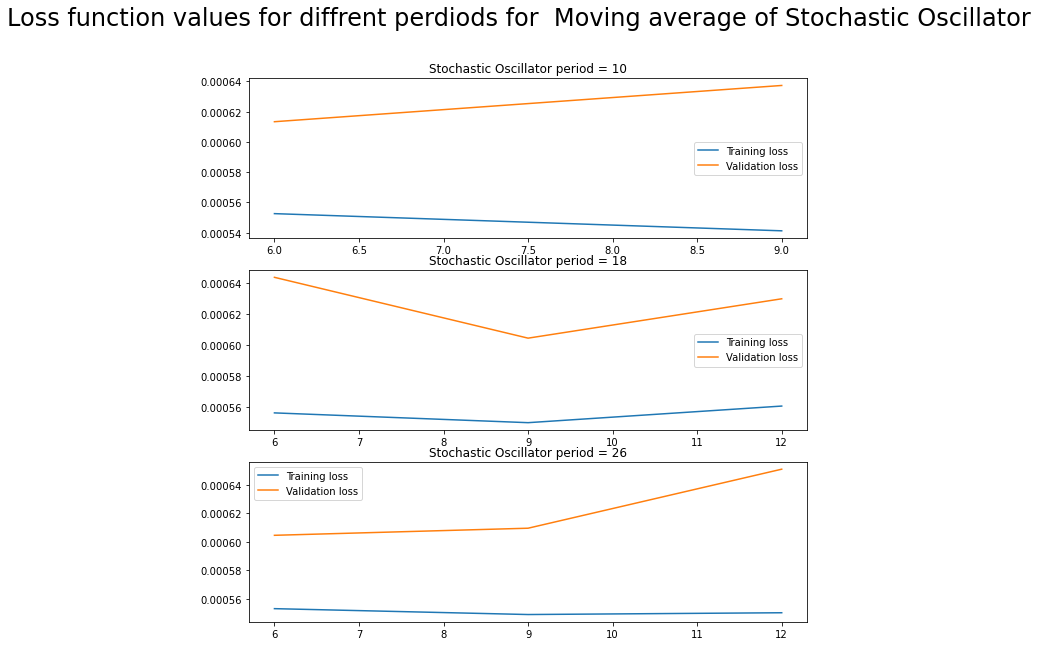

In [38]:
fig, axes = plt.subplots(len(results_MACD['long_period'].unique()))
fig.set_size_inches(10,10)
fig.suptitle('Loss function values for diffrent perdiods for  Moving average of Stochastic Oscillator', size=24)

axes_counter = 0
for long_period in results_MACD['long_period'].unique():
    axes[axes_counter].title.set_text('Stochastic Oscillator period = ' + str(long_period))
    axes[axes_counter].plot(results_MACD['short_period'].where(results_MACD['long_period']==long_period), results_MACD[['loss', 'val_loss']].where(results_MACD['long_period']==long_period))
    axes[axes_counter].legend(['Training loss',  'Validation loss'])
    axes_counter += 1

In [39]:
long_period = 26
short_period = 12
signal_periods = [3, 5, 9, 12]

X_all = []
Y_all = []
results_MACD_histogram = []


for signal_period in signal_periods:
    X_all = []
    Y_all = []
    stocks = []
    # prepare data
    for stock in stock_data_list:
        stock = get_MACD_histogram(stock, long_period, short_period, signal_period)
        stock = stock.dropna()
        scaled_stock, stock_scaler = scale_data(stock.drop(columns='Date'))
        stocks.append(scaled_stock)
    # split for training and validation
    for stock in stocks:
        X, Y = prepare_input_and_output(np.array(stock))
        X_all = X_all + X
        Y_all = Y_all + Y
    X_all, Y_all = np.array(X_all), np.array(Y_all)
    X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=0.1, shuffle=False)
    print(X_train.shape)
    print(X_valid.shape)
    print(Y_train.shape)
    print(Y_valid.shape)
    #
    print('Signal line period: ' + str(signal_period))
    loss_results = []
    val_loss_results = []
    for i in range(3):
        model = Sequential()
        model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
        model.add(Dense(10, activation='relu'))
        model.add(Dense(Y_train.shape[1]))
        model.compile(loss='mse', optimizer='adam')
        history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
        loss_results.append(history.history['loss'][-1])
        val_loss_results.append(history.history['val_loss'][-1])
    results_MACD_histogram.append({'long_period': long_period,'short_period': short_period,'signal_period': signal_period, 'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})
results_MACD_histogram = pd.DataFrame(results_MACD_histogram)


(25886, 60, 12)
(2877, 60, 12)
(25886, 5)
(2877, 5)
Signal line period: 3
Epoch 1/7
809/809 [==============================] - 6s 6ms/step - loss: 0.0062 - val_loss: 7.6564e-04
Epoch 2/7
809/809 [==============================] - 5s 6ms/step - loss: 6.6437e-04 - val_loss: 6.4477e-04
Epoch 3/7
809/809 [==============================] - 5s 6ms/step - loss: 5.7370e-04 - val_loss: 6.7070e-04
Epoch 4/7
809/809 [==============================] - 5s 6ms/step - loss: 6.3621e-04 - val_loss: 6.5896e-04
Epoch 5/7
809/809 [==============================] - 5s 6ms/step - loss: 5.3404e-04 - val_loss: 6.0748e-04
Epoch 6/7
809/809 [==============================] - 5s 6ms/step - loss: 5.1514e-04 - val_loss: 5.9717e-04
Epoch 7/7
809/809 [==============================] - 5s 6ms/step - loss: 5.4433e-04 - val_loss: 6.0450e-04
Epoch 1/7
809/809 [==============================] - 6s 6ms/step - loss: 0.0179 - val_loss: 0.0011
Epoch 2/7
809/809 [==============================] - 5s 6ms/step - loss: 6.6647e-0

809/809 [==============================] - 5s 6ms/step - loss: 6.0667e-04 - val_loss: 6.2824e-04
Epoch 6/7
809/809 [==============================] - 5s 6ms/step - loss: 5.5137e-04 - val_loss: 5.9665e-04
Epoch 7/7
809/809 [==============================] - 5s 6ms/step - loss: 5.4467e-04 - val_loss: 6.1031e-04
Epoch 1/7
809/809 [==============================] - 6s 6ms/step - loss: 0.0108 - val_loss: 7.2598e-04
Epoch 2/7
809/809 [==============================] - 5s 6ms/step - loss: 6.4481e-04 - val_loss: 6.7444e-04
Epoch 3/7
809/809 [==============================] - 5s 6ms/step - loss: 5.9348e-04 - val_loss: 6.3156e-04
Epoch 4/7
809/809 [==============================] - 5s 6ms/step - loss: 5.5416e-04 - val_loss: 6.0452e-04
Epoch 5/7
809/809 [==============================] - 5s 6ms/step - loss: 5.6567e-04 - val_loss: 6.9043e-04
Epoch 6/7
809/809 [==============================] - 5s 6ms/step - loss: 5.7519e-04 - val_loss: 6.4815e-04
Epoch 7/7
809/809 [==============================] 

In [40]:
results_MACD_histogram

,long_period,short_period,signal_period,loss,val_loss
0,26,12,3,0.000550,0.000633
1,26,12,5,0.000560,0.000627
2,26,12,9,0.000554,0.000659
3,26,12,12,0.000554,0.000646


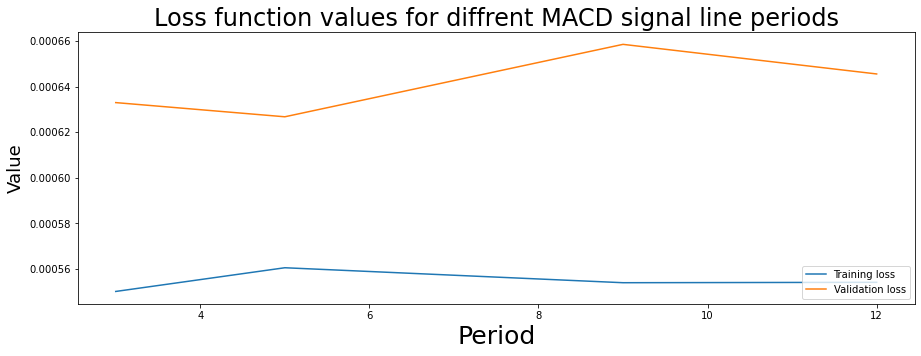

In [41]:
plt.figure(figsize=(15,5))
plt.title('Loss function values for diffrent MACD signal line periods', fontsize=24)
plt.xlabel('Period', fontsize=25)
plt.ylabel('Value', fontsize=18)
plt.plot(results_MACD_histogram['signal_period'], results_MACD_histogram[['loss', 'val_loss']])
plt.legend(['Training loss',  'Validation loss'], loc='lower right')
plt.show()

## Triple exponential moving average TEMA

In [42]:
periods = [3, 5, 9, 12]

X_all = []
Y_all = []
results_TEMA = []


for period in periods:
    X_all = []
    Y_all = []
    stocks = []
    # prepare data
    for stock in stock_data_list:
        stock = get_TEMA(stock, period)
        stock = stock.dropna()
        scaled_stock, stock_scaler = scale_data(stock.drop(columns='Date'))
        stocks.append(scaled_stock)
    # split for training and validation
    for stock in stocks:
        X, Y = prepare_input_and_output(np.array(stock))
        X_all = X_all + X
        Y_all = Y_all + Y
    X_all, Y_all = np.array(X_all), np.array(Y_all)
    X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=0.1, shuffle=False)
    print(X_train.shape)
    print(X_valid.shape)
    print(Y_train.shape)
    print(Y_valid.shape)
    #
    print('TEMA period: ' + str(period))
    loss_results = []
    val_loss_results = []
    for i in range(3):
        model = Sequential()
        model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
        model.add(Dense(10, activation='relu'))
        model.add(Dense(Y_train.shape[1]))
        model.compile(loss='mse', optimizer='adam')
        history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
        loss_results.append(history.history['loss'][-1])
        val_loss_results.append(history.history['val_loss'][-1])
    results_TEMA.append({'period': period, 'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})
results_TEMA = pd.DataFrame(results_TEMA)


(25886, 60, 13)
(2877, 60, 13)
(25886, 5)
(2877, 5)
TEMA period: 3
Epoch 1/7
809/809 [==============================] - 6s 6ms/step - loss: 0.0077 - val_loss: 7.8740e-04
Epoch 2/7
809/809 [==============================] - 5s 6ms/step - loss: 7.2666e-04 - val_loss: 6.5460e-04
Epoch 3/7
809/809 [==============================] - 5s 6ms/step - loss: 6.6203e-04 - val_loss: 6.4388e-04
Epoch 4/7
809/809 [==============================] - 5s 6ms/step - loss: 5.9027e-04 - val_loss: 6.3876e-04
Epoch 5/7
809/809 [==============================] - 5s 6ms/step - loss: 6.4455e-04 - val_loss: 6.0637e-04
Epoch 6/7
809/809 [==============================] - 5s 6ms/step - loss: 5.4083e-04 - val_loss: 6.1925e-04
Epoch 7/7
809/809 [==============================] - 5s 6ms/step - loss: 5.4561e-04 - val_loss: 6.0944e-04
Epoch 1/7
809/809 [==============================] - 6s 6ms/step - loss: 0.0099 - val_loss: 8.3643e-04
Epoch 2/7
809/809 [==============================] - 5s 6ms/step - loss: 7.6289e-04 -

809/809 [==============================] - 5s 6ms/step - loss: 0.0011 - val_loss: 9.4145e-04
Epoch 6/7
809/809 [==============================] - 5s 6ms/step - loss: 0.0011 - val_loss: 9.3478e-04
Epoch 7/7
809/809 [==============================] - 5s 6ms/step - loss: 0.0011 - val_loss: 9.4690e-04
Epoch 1/7
809/809 [==============================] - 6s 6ms/step - loss: 0.0055 - val_loss: 6.9691e-04
Epoch 2/7
809/809 [==============================] - 5s 6ms/step - loss: 6.0879e-04 - val_loss: 7.7526e-04
Epoch 3/7
809/809 [==============================] - 5s 6ms/step - loss: 6.1502e-04 - val_loss: 6.1664e-04
Epoch 4/7
809/809 [==============================] - 5s 6ms/step - loss: 5.5649e-04 - val_loss: 7.0610e-04
Epoch 5/7
809/809 [==============================] - 5s 6ms/step - loss: 5.8846e-04 - val_loss: 6.1106e-04
Epoch 6/7
809/809 [==============================] - 5s 6ms/step - loss: 5.8009e-04 - val_loss: 6.1185e-04
Epoch 7/7
809/809 [==============================] - 5s 6ms/ste

In [43]:
results_TEMA

,period,loss,val_loss
0,3,0.000555,0.000641
1,5,0.000551,0.000637
2,9,0.000560,0.000644
3,12,0.000741,0.000794


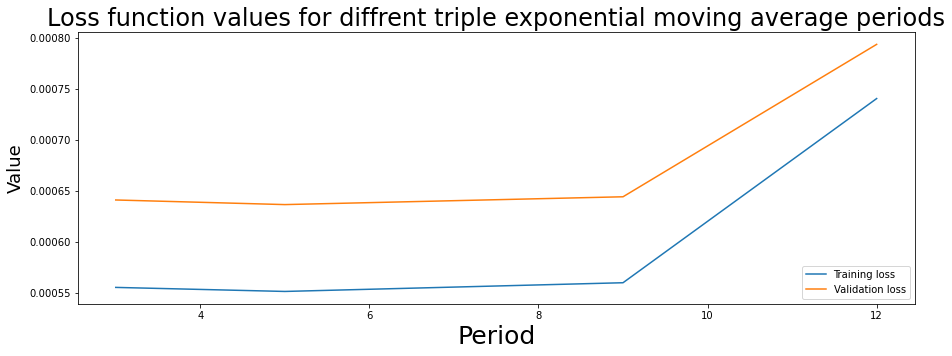

In [44]:
plt.figure(figsize=(15,5))
plt.title('Loss function values for diffrent triple exponential moving average periods', fontsize=24)
plt.xlabel('Period', fontsize=25)
plt.ylabel('Value', fontsize=18)
plt.plot(results_TEMA['period'], results_TEMA[['loss', 'val_loss']])
plt.legend(['Training loss',  'Validation loss'], loc='lower right')
plt.axhline(0.000444, color='r', label = 'Loss without indicator')
plt.show()

## Commodity Channel  Index CGI

In [45]:
periods = [5, 10, 15, 20]

X_all = []
Y_all = []
results_CGI = []


for period in periods:
    X_all = []
    Y_all = []
    stocks = []
    # prepare data
    for stock in stock_data_list:
        stock = get_CGI(stock, period)
        stock = stock.dropna()
        scaled_stock, stock_scaler = scale_data(stock.drop(columns='Date'))
        stocks.append(scaled_stock)
    # split for training and validation
    for stock in stocks:
        X, Y = prepare_input_and_output(np.array(stock))
        X_all = X_all + X
        Y_all = Y_all + Y
    X_all, Y_all = np.array(X_all), np.array(Y_all)
    X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=0.1, shuffle=False)
    print(X_train.shape)
    print(X_valid.shape)
    print(Y_train.shape)
    print(Y_valid.shape)
    #
    print('CGI period: ' + str(period))
    loss_results = []
    val_loss_results = []
    for i in range(3):
        model = Sequential()
        model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
        model.add(Dense(10, activation='relu'))
        model.add(Dense(Y_train.shape[1]))
        model.compile(loss='mse', optimizer='adam')
        history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
        loss_results.append(history.history['loss'][-1])
        val_loss_results.append(history.history['val_loss'][-1])
    results_CGI.append({'period': period, 'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})
results_CGI = pd.DataFrame(results_CGI)


(25886, 60, 14)
(2877, 60, 14)
(25886, 5)
(2877, 5)
CGI period: 5
Epoch 1/7
809/809 [==============================] - 6s 6ms/step - loss: 0.0122 - val_loss: 9.5925e-04
Epoch 2/7
809/809 [==============================] - 5s 6ms/step - loss: 8.9730e-04 - val_loss: 6.7689e-04
Epoch 3/7
809/809 [==============================] - 5s 6ms/step - loss: 6.3115e-04 - val_loss: 6.5071e-04
Epoch 4/7
809/809 [==============================] - 4s 6ms/step - loss: 6.1164e-04 - val_loss: 6.8495e-04
Epoch 5/7
809/809 [==============================] - 5s 6ms/step - loss: 5.6980e-04 - val_loss: 7.0719e-04
Epoch 6/7
809/809 [==============================] - 5s 6ms/step - loss: 5.3984e-04 - val_loss: 7.6010e-04
Epoch 7/7
809/809 [==============================] - 5s 6ms/step - loss: 5.6838e-04 - val_loss: 6.0070e-04
Epoch 1/7
809/809 [==============================] - 6s 6ms/step - loss: 0.0093 - val_loss: 7.7618e-04
Epoch 2/7
809/809 [==============================] - 5s 6ms/step - loss: 7.6638e-04 - 

809/809 [==============================] - 6s 7ms/step - loss: 5.4149e-04 - val_loss: 7.4727e-04
Epoch 6/7
809/809 [==============================] - 5s 6ms/step - loss: 6.0813e-04 - val_loss: 6.5036e-04
Epoch 7/7
809/809 [==============================] - 5s 6ms/step - loss: 5.5753e-04 - val_loss: 6.5411e-04
Epoch 1/7
809/809 [==============================] - 7s 7ms/step - loss: 0.0181 - val_loss: 6.9630e-04
Epoch 2/7
809/809 [==============================] - 5s 7ms/step - loss: 6.6229e-04 - val_loss: 6.6757e-04
Epoch 3/7
809/809 [==============================] - 5s 7ms/step - loss: 5.5709e-04 - val_loss: 6.1452e-04
Epoch 4/7
809/809 [==============================] - 5s 7ms/step - loss: 6.1279e-04 - val_loss: 6.4676e-04
Epoch 5/7
809/809 [==============================] - 6s 7ms/step - loss: 5.6315e-04 - val_loss: 6.4298e-04
Epoch 6/7
809/809 [==============================] - 5s 7ms/step - loss: 5.8269e-04 - val_loss: 6.2447e-04
Epoch 7/7
809/809 [==============================] 

In [46]:
results_CGI

,period,loss,val_loss
0,5,0.000555,0.000616
1,10,0.000562,0.000632
2,15,0.000555,0.000628
3,20,0.000554,0.000681


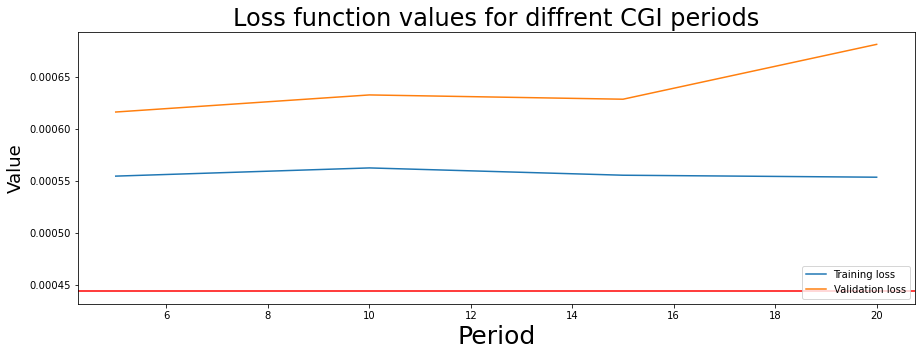

In [47]:
plt.figure(figsize=(15,5))
plt.title('Loss function values for diffrent CGI periods', fontsize=24)
plt.xlabel('Period', fontsize=25)
plt.ylabel('Value', fontsize=18)
plt.plot(results_CGI['period'], results_CGI[['loss', 'val_loss']])
plt.legend(['Training loss',  'Validation loss'], loc='lower right')
plt.axhline(0.000444, color='r', label = 'Loss without indicator')
plt.show()

## Williams Percent Range WPI

In [48]:
periods = [5, 7, 10, 14, 21]

X_all = []
Y_all = []
results_WPI = []


for period in periods:
    X_all = []
    Y_all = []
    stocks = []
    # prepare data
    for stock in stock_data_list:
        stock = get_Williams_Percent_Range(stock, period)
        stock = stock.dropna()
        scaled_stock, stock_scaler = scale_data(stock.drop(columns='Date'))
        stocks.append(scaled_stock)
    # split for training and validation
    for stock in stocks:
        X, Y = prepare_input_and_output(np.array(stock))
        X_all = X_all + X
        Y_all = Y_all + Y
    X_all, Y_all = np.array(X_all), np.array(Y_all)
    X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=0.1, shuffle=False)
    print(X_train.shape)
    print(X_valid.shape)
    print(Y_train.shape)
    print(Y_valid.shape)
    #
    print('WPI period: ' + str(period))
    loss_results = []
    val_loss_results = []
    for i in range(3):
        model = Sequential()
        model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
        model.add(Dense(10, activation='relu'))
        model.add(Dense(Y_train.shape[1]))
        model.compile(loss='mse', optimizer='adam')
        history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
        loss_results.append(history.history['loss'][-1])
        val_loss_results.append(history.history['val_loss'][-1])
    results_WPI.append({'period': period, 'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})
results_WPI = pd.DataFrame(results_WPI)


(25886, 60, 15)
(2877, 60, 15)
(25886, 5)
(2877, 5)
WPI period: 5
Epoch 1/7
809/809 [==============================] - 7s 7ms/step - loss: 0.0088 - val_loss: 7.2137e-04
Epoch 2/7
809/809 [==============================] - 6s 7ms/step - loss: 6.5044e-04 - val_loss: 6.7741e-04
Epoch 3/7
809/809 [==============================] - 5s 6ms/step - loss: 6.1833e-04 - val_loss: 6.9565e-04
Epoch 4/7
809/809 [==============================] - 5s 6ms/step - loss: 5.9763e-04 - val_loss: 6.7929e-04
Epoch 5/7
809/809 [==============================] - 6s 7ms/step - loss: 5.6910e-04 - val_loss: 6.3083e-04
Epoch 6/7
809/809 [==============================] - 6s 8ms/step - loss: 6.1178e-04 - val_loss: 6.2883e-04
Epoch 7/7
809/809 [==============================] - 6s 8ms/step - loss: 5.7881e-04 - val_loss: 6.1210e-04
Epoch 1/7
809/809 [==============================] - 7s 8ms/step - loss: 0.0063 - val_loss: 7.8042e-04
Epoch 2/7
809/809 [==============================] - 5s 6ms/step - loss: 6.5594e-04 - 

809/809 [==============================] - 5s 7ms/step - loss: 5.9935e-04 - val_loss: 6.0574e-04
Epoch 6/7
809/809 [==============================] - 5s 7ms/step - loss: 5.0943e-04 - val_loss: 6.3369e-04
Epoch 7/7
809/809 [==============================] - 5s 7ms/step - loss: 5.7103e-04 - val_loss: 6.3662e-04
Epoch 1/7
809/809 [==============================] - 7s 8ms/step - loss: 0.0508 - val_loss: 0.0024
Epoch 2/7
809/809 [==============================] - 6s 7ms/step - loss: 0.0012 - val_loss: 8.6842e-04
Epoch 3/7
809/809 [==============================] - 6s 8ms/step - loss: 8.2000e-04 - val_loss: 6.8602e-04
Epoch 4/7
809/809 [==============================] - 6s 8ms/step - loss: 7.3613e-04 - val_loss: 6.5214e-04
Epoch 5/7
809/809 [==============================] - 6s 8ms/step - loss: 6.0323e-04 - val_loss: 6.4501e-04
Epoch 6/7
809/809 [==============================] - 6s 8ms/step - loss: 5.9737e-04 - val_loss: 5.9998e-04
Epoch 7/7
809/809 [==============================] - 6s 7ms

In [49]:
results_WPI

,period,loss,val_loss
0,5,0.000552,0.000650
1,7,0.000554,0.000652
2,10,0.000554,0.000609
3,14,0.000556,0.000658
4,21,0.000556,0.000630


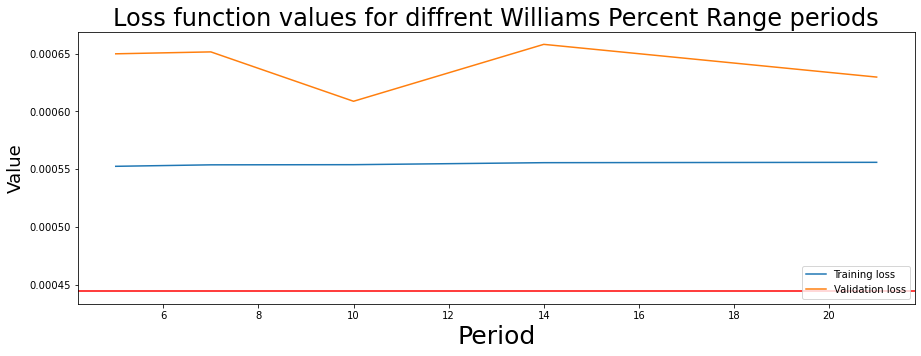

In [50]:
plt.figure(figsize=(15,5))
plt.title('Loss function values for diffrent Williams Percent Range periods', fontsize=24)
plt.xlabel('Period', fontsize=25)
plt.ylabel('Value', fontsize=18)
plt.plot(results_WPI['period'], results_WPI[['loss', 'val_loss']])
plt.legend(['Training loss',  'Validation loss'], loc='lower right')
plt.axhline(0.000444, color='r', label = 'Loss without indicator')
plt.show()

In [55]:
end = time.time()
print('Time of executing the script: ' + str(round((end - start)/3600, 2)) + 'h')

Time of executing the script: 1.53h
